<a href="https://colab.research.google.com/github/AbdurRafiq/Machine-Learning-Algorithms-With-Python/blob/master/outlierdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [0]:

data = pd.read_csv("/content/drive/My Drive/content/gdrive/rafiq/provider.csv")
data.head()

,npi,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt,FRAUD
0,1003127655,617.0,499,617,219.944716,332.463533,170.918590,160.501297,1
1,1003127655,249.0,17,249,42.570080,69.899598,33.024418,30.899317,1
2,1003127655,1220.0,235,1220,78.414213,120.000000,61.340197,57.327828,1
3,1003127655,754.0,434,754,113.284987,172.590186,88.611313,83.092427,1
4,1003127655,543.0,448,543,117.852320,188.176796,91.907495,85.472413,1


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
npi                              100000 non-null int64
line_srvc_cnt                    100000 non-null float64
bene_unique_cnt                  100000 non-null int64
bene_day_srvc_cnt                100000 non-null int64
average_Medicare_allowed_amt     100000 non-null float64
average_submitted_chrg_amt       100000 non-null float64
average_Medicare_payment_amt     100000 non-null float64
average_Medicare_standard_amt    100000 non-null float64
FRAUD                            100000 non-null int64
dtypes: float64(5), int64(4)
memory usage: 6.9 MB


In [0]:

data.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

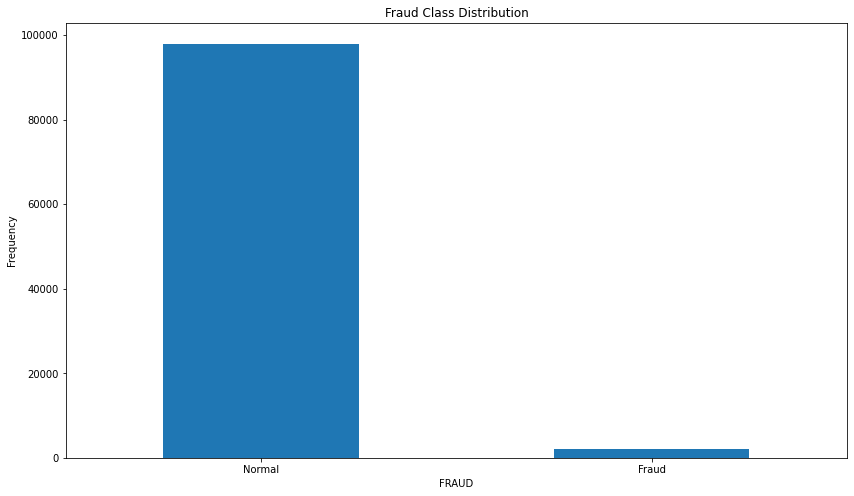

In [0]:
count_classes = pd.value_counts(data['FRAUD'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Fraud Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("FRAUD")

plt.ylabel("Frequency")

In [0]:
fraud = data[data['FRAUD']==1]

normal = data[data['FRAUD']==0]

In [0]:
print(fraud.shape,normal.shape)

(2050, 9) (97950, 9)


In [0]:
fraud.average_submitted_chrg_amt.describe()

count     2050.000000
mean       251.580599
std        871.092233
min          0.468966
25%         54.229167
50%        134.980469
75%        242.000000
max      23150.550000
Name: average_submitted_chrg_amt, dtype: float64

In [0]:
normal.average_submitted_chrg_amt.describe()

count    97950.000000
mean       343.102786
std        965.374609
min          0.010000
25%         58.047408
50%        147.000000
75%        300.000000
max      75344.925926
Name: average_submitted_chrg_amt, dtype: float64

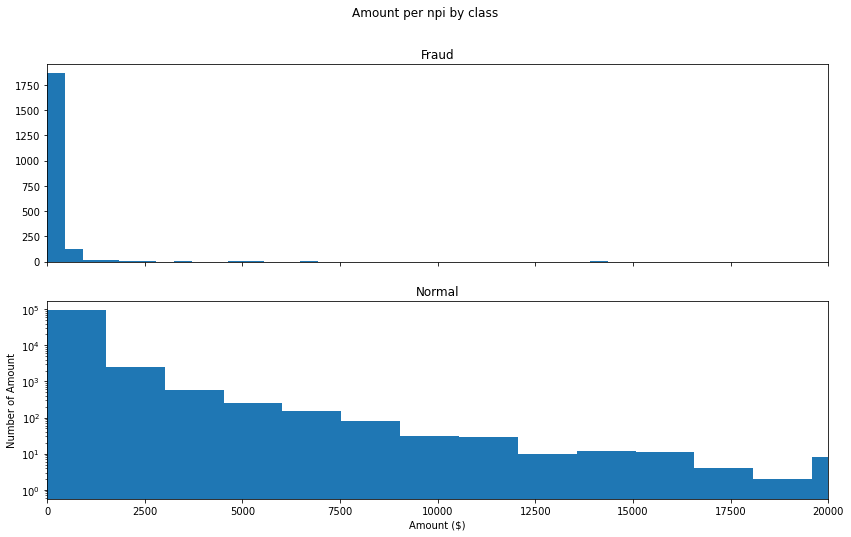

In [0]:

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per npi by class')
bins = 50
ax1.hist(fraud.average_submitted_chrg_amt, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.average_submitted_chrg_amt, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Amount')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

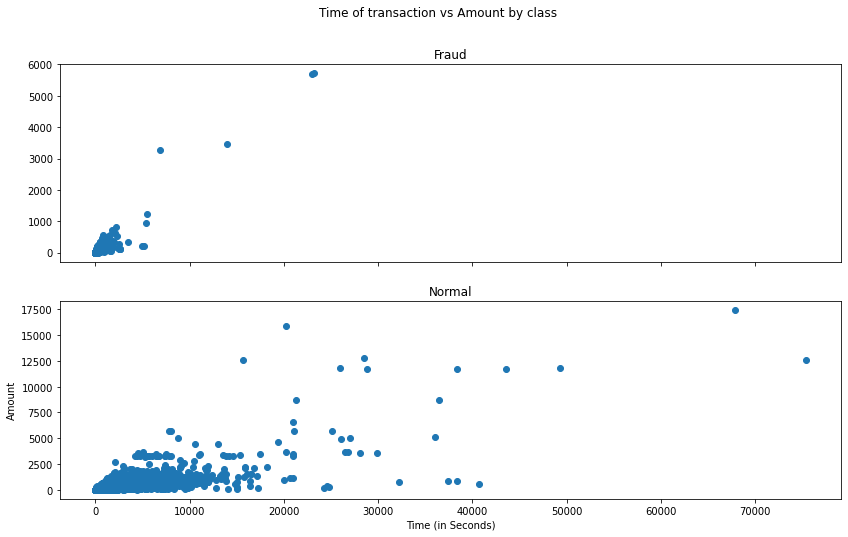

In [0]:
# We Will check Do fraudulent  occur more often during certain time frame ? 

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.average_submitted_chrg_amt, fraud.average_Medicare_standard_amt)
ax1.set_title('Fraud')
ax2.scatter(normal.average_submitted_chrg_amt, normal.average_Medicare_standard_amt)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [0]:
data1= data.sample(frac = .5,random_state=1)

data1.shape

(50000, 9)

In [0]:
data.shape

(100000, 9)

In [0]:

Fraud = data1[data1['FRAUD']==1]

Valid = data1[data1['FRAUD']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [0]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.020803985218758293
Fraud Cases : 1019
Valid Cases : 48981


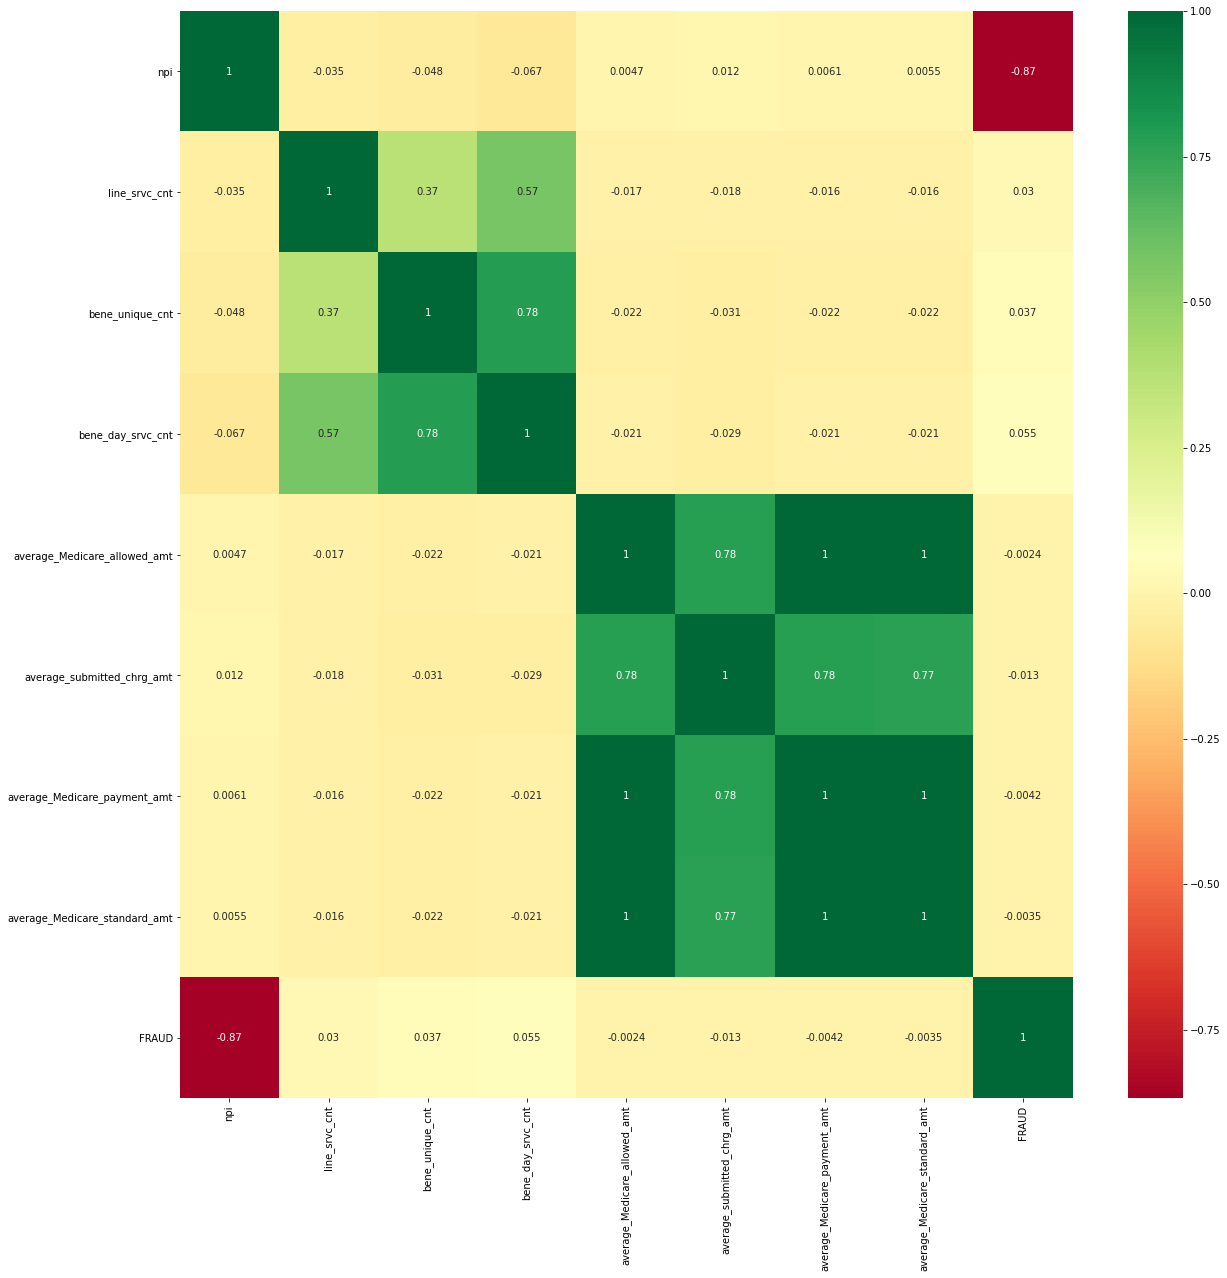

In [0]:
## Correlation
import seaborn as sns
#get correlations of each features in dataset
corrmat = data1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [0]:
columns = data1.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["FRAUD"]]
# Store the variable we are predicting 
target = "FRAUD"
# Define a random state 
state = np.random.RandomState(42)
X = data1[columns]
Y = data1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(50000, 8)
(50000,)


In [0]:

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=40, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
   "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

In [0]:
type(classifiers)

dict

In [0]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 1116
Accuracy Score :
0.97768
Classification Report :
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     48981
           1       0.45      0.46      0.46      1019

    accuracy                           0.98     50000
   macro avg       0.72      0.73      0.72     50000
weighted avg       0.98      0.98      0.98     50000

Local Outlier Factor: 1830
Accuracy Score :
0.9634
Classification Report :
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     48981
           1       0.11      0.11      0.11      1019

    accuracy                           0.96     50000
   macro avg       0.55      0.55      0.55     50000
weighted avg       0.96      0.96      0.96     50000

Support Vector Machine: 18361
Accuracy Score :
0.63278
Classification Report :
              precision    recall  f1-score   support

           0       0.98      0.64      0.77     48981
           

In [0]:
roc = roc_auc_score(y_pred, scores_prediction)
print(f'ROC score is {roc}')

ROC score is 0.0
